# Setup

In [78]:
import cv2
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import sys
from utils import load_and_preprocess, visualize_prediction, visualize_overlay
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

PROJECT_ROOT = Path().resolve()
sys.path.insert(0, str(PROJECT_ROOT))

from config import DATA_DIR, OUTPUT_DIR, PREDICTIONS_DIR, MODELS_DIR, ensure_dirs
ensure_dirs()

print(f"Project root: {PROJECT_ROOT}")
print(f"Models dir: {MODELS_DIR}")


Project root: /Users/huy/src/dentalml/reference_projects/Segmentation-of-Teeth-in-Panoramic-X-ray-Image-Using-U-Net
Models dir: /Users/huy/src/dentalml/reference_projects/Segmentation-of-Teeth-in-Panoramic-X-ray-Image-Using-U-Net/output/models


In [80]:
from model import UNET

MODEL_PATH = MODELS_DIR / 'dental_xray_seg.h5'
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Model not found at {MODEL_PATH}")

model = UNET(input_shape=(512,512,1), last_activation='sigmoid')

model.load_weights(str(MODEL_PATH))

print(f"Loaded model weights from: {MODEL_PATH}")
print(f"Input shape: {model.input_shape}")
print(f"Output shape: {model.output_shape}")

Loaded model weights from: /Users/huy/src/dentalml/reference_projects/Segmentation-of-Teeth-in-Panoramic-X-ray-Image-Using-U-Net/output/models/dental_xray_seg.h5
Input shape: (None, 512, 512, 1)
Output shape: (None, 512, 512, 1)


In [81]:
def run_inference(model, image: np.ndarray, threshold: float = 0.25) -> np.ndarray:
    prediction = model.predict(image, verbose=0)
    mask = prediction[0, :, :, 0]
    binary_mask = (mask > threshold).astype(np.uint8) * 255
    return mask, binary_mask

# Inference

In [82]:
from natsort import natsorted

IMAGES_DIR = DATA_DIR / 'Images'
available_images = natsorted(list(IMAGES_DIR.glob('*.png')))
print(f"Available images: {len(available_images)} [{', '.join(str(img.name) for img in available_images[:3])}, ...]")

Available images: 116 [1.png, 2.png, 3.png, ...]


In [83]:
SAMPLE_IMAGE_INDEX = 107
image_path = IMAGES_DIR / f'{SAMPLE_IMAGE_INDEX}.png'
print(f"Selected image: {image_path}")

Selected image: /Users/huy/src/dentalml/reference_projects/Segmentation-of-Teeth-in-Panoramic-X-ray-Image-Using-U-Net/data/Images/107.png


In [84]:
preprocessed, original = load_and_preprocess(image_path)
raw_prediction, binary_mask = run_inference(model, preprocessed, threshold=0.25)

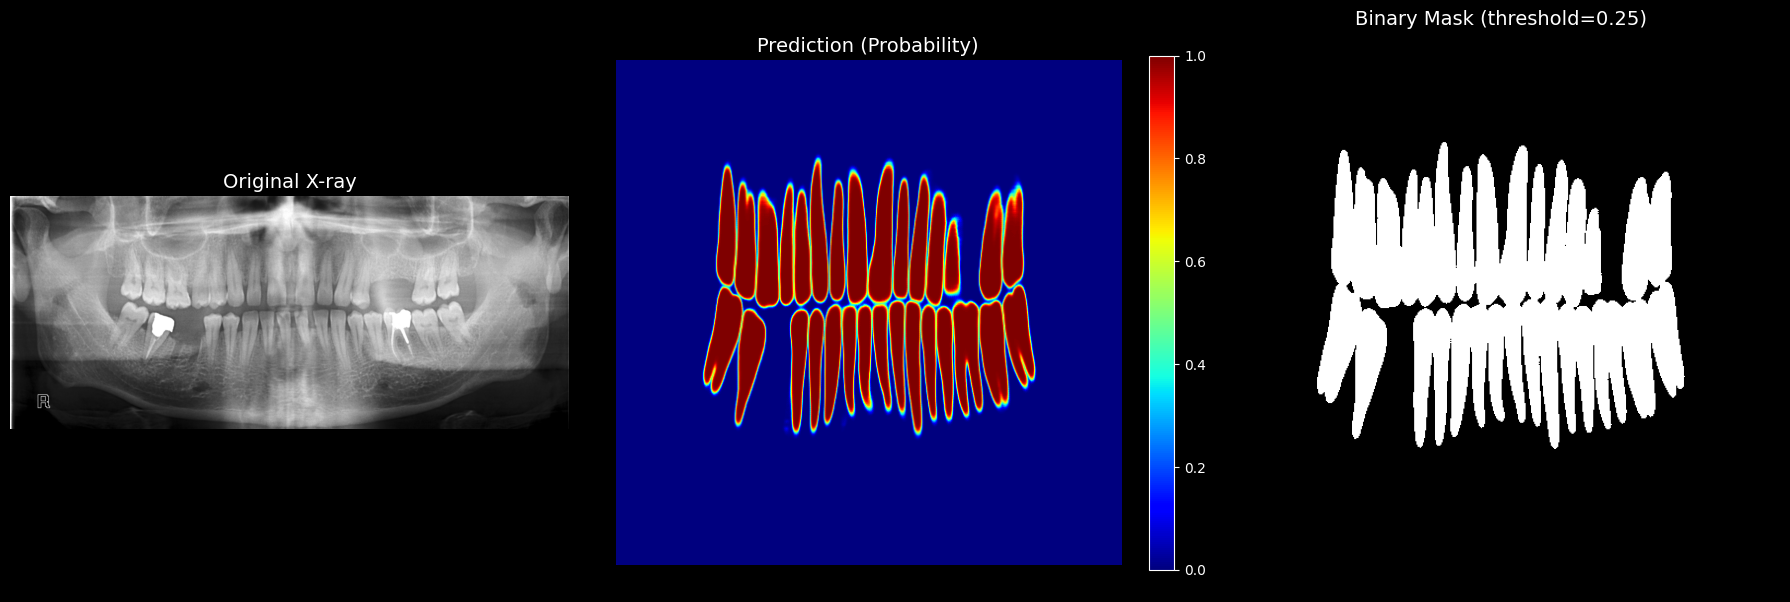

In [85]:
visualize_prediction(original, raw_prediction, binary_mask)

In [86]:
prediction_resized = cv2.resize(raw_prediction, (original.shape[1], original.shape[0]),
                                interpolation=cv2.INTER_LANCZOS4)

# Create binary mask at original resolution
mask_uint8 = np.uint8(prediction_resized * 255)
_, mask_binary = cv2.threshold(mask_uint8, thresh=255 // 2, maxval=255, type=cv2.THRESH_BINARY)

# Find and draw contours
contours, _ = cv2.findContours(mask_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

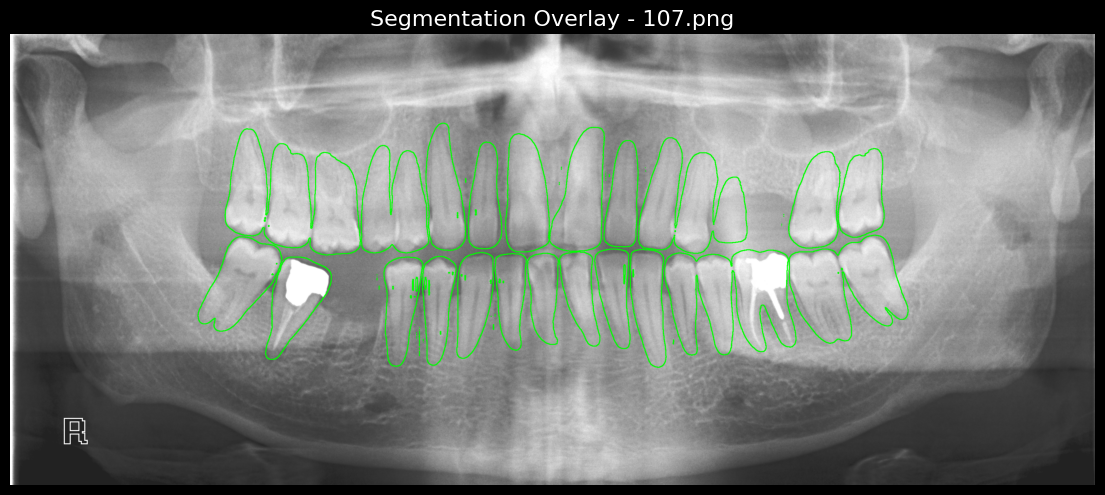

In [87]:
if len(original.shape) == 2:
    overlay = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
else:
    overlay = original.copy()

cv2.drawContours(overlay, contours, -1, (0, 255, 0), 2)

# Display
plt.figure(figsize=(14, 10))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title(f'Segmentation Overlay - {image_path.name}', fontsize=16)
plt.axis('off')
plt.show()

# CCA & Edentulous Zoning

In [88]:
from tooth_analysis import (
    analyze_dental_panorama,
    visualize_analysis,
    print_analysis_report
)
import cv2

img_bgr = cv2.imread(str(image_path))

prediction_bgr = cv2.cvtColor(mask_uint8, cv2.COLOR_GRAY2BGR)
prediction_bgr = cv2.resize(prediction_bgr, (img_bgr.shape[1], img_bgr.shape[0]), interpolation=cv2.INTER_LANCZOS4)

# Run the full dental analysis on the prediction
# prediction_bgr is already prepared from the CCA section above
analysis_result = analyze_dental_panorama(
    prediction_mask=prediction_bgr,
    image_shape=img_bgr.shape[:2],
    erode_iterations=3,
    open_iterations=2,
    min_tooth_area=2000,
    gap_threshold=2,
)

print(f"Analysis complete!")
print(f"Detected teeth: {analysis_result.total_detected}")
print(f"Missing teeth: {analysis_result.total_missing}")
print(f"Reference count: {analysis_result.reference_count}")

Analysis complete!
Detected teeth: 29
Missing teeth: 2
Reference count: 31


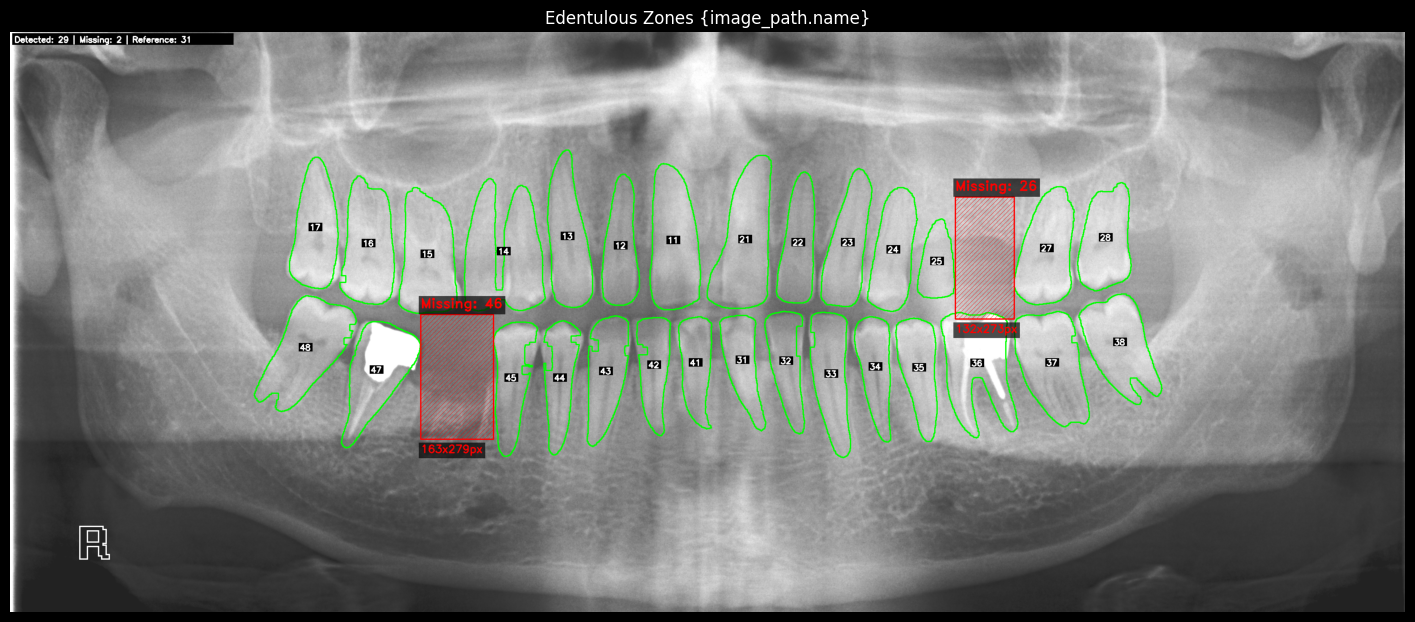

In [89]:
analysis_viz = visualize_analysis(
    original_image=img_bgr,
    result=analysis_result,
    show_fdi_labels=True,
    show_zones=True,
    show_measurements=True,
)

plt.figure(figsize=(18, 12))
plt.imshow(cv2.cvtColor(analysis_viz, cv2.COLOR_BGR2RGB))
plt.title("Edentulous Zones {image_path.name}")
plt.axis('off')
plt.show()

# Physical Measurement Projection

## Method 1: Infere Priors from image dimensions

In [90]:
from physical_metrics import (
    create_priors_from_image_dimensions,
    print_physical_measurement_report,
)
from tooth_analysis import convert_zones_to_physical, visualize_analysis_physical
# Get original image dimensions
original_height, original_width = original.shape[:2]
print(f"Original image dimensions: {original_width} x {original_height} px")

# X800 panoramic FOV is approximately 240-300mm wide
# Using 270mm as typical value
priors_fov = create_priors_from_image_dimensions(
    image_width_px=original_width,
    image_height_px=original_height,
    fov_width_mm=270.0,  # Typical X800 panoramic FOV
    machine="X800"
)
print(f"\nCalibration Method: {priors_fov.calibration_method}")
print(f"Pixel spacing: {priors_fov.get_effective_pixel_spacing():.4f} mm/px")
print(f"Calibrated: {priors_fov.is_calibrated()}")
zones_physical = convert_zones_to_physical(analysis_result, priors_fov)

# Print detailed physical measurement report
# _ = print_physical_measurement_report(zones_physical, priors_fov)

Original image dimensions: 3126 x 1300 px

Calibration Method: assumed_fov
Pixel spacing: 0.0864 mm/px
Calibrated: False


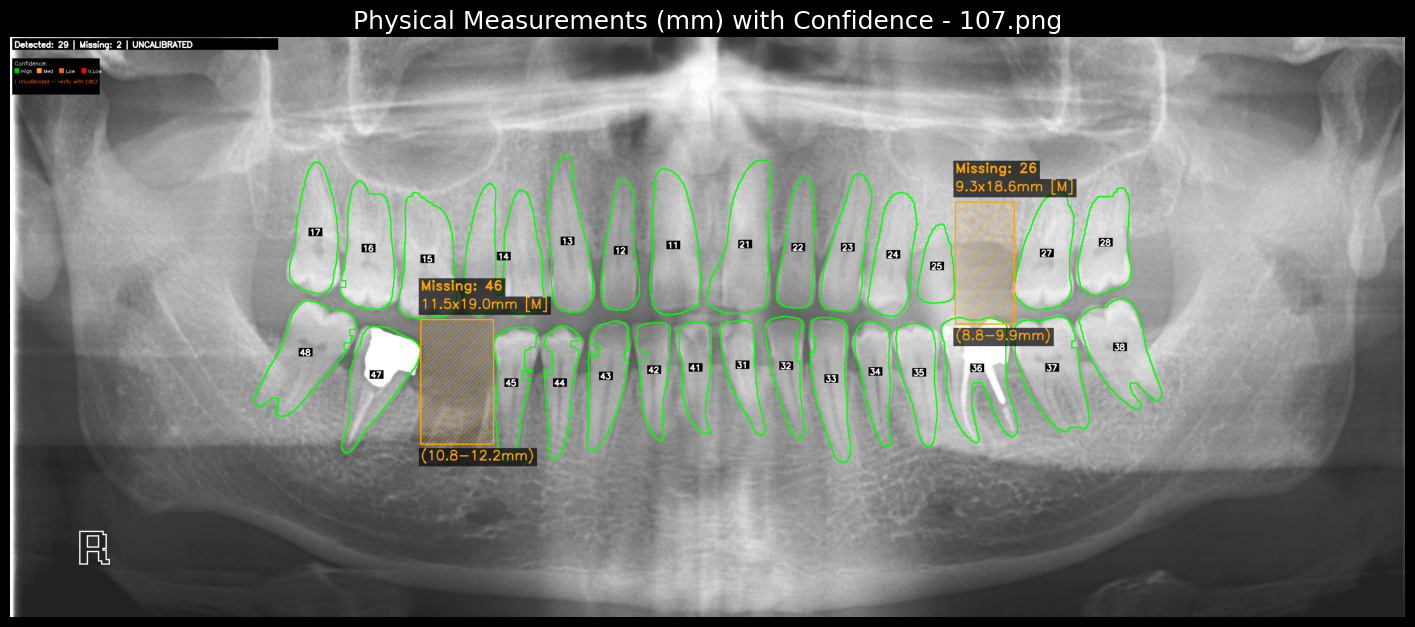

In [91]:
analysis_viz_physical = visualize_analysis_physical(
    original_image=img_bgr,
    result=analysis_result,
    priors=priors_fov,
    show_fdi_labels=True,
    show_zones=True,
    show_measurements=True,
    show_confidence=True,
)
plt.figure(figsize=(18, 12))
plt.imshow(cv2.cvtColor(analysis_viz_physical, cv2.COLOR_BGR2RGB))
plt.title(f'Physical Measurements (mm) with Confidence - {image_path.name}', fontsize=18)
plt.axis('off')
plt.show()

In [92]:
from pano_geometry_viz import (
    create_xray_geometry_animation,
    create_magnification_chart,
    create_panoramic_geometry_visualization,
    print_geometry_insights,
)

METHOD_1_LABEL = f"Method 1: FOV-based ({priors_fov.calibration_method})"
METHOD_1_SUBTITLE = f"Pixel spacing: {priors_fov.get_effective_pixel_spacing():.4f} mm/px | Calibrated: {priors_fov.is_calibrated()}"

# X-ray rotation animation (same for both methods - shows physics)
fig_rotation = create_xray_geometry_animation(title_suffix="X-ray source rotation principle")
fig_rotation.show()

# Magnification bar chart for Method 1
fig_mf_1 = create_magnification_chart(priors_fov, title_suffix=METHOD_1_SUBTITLE)
fig_mf_1.show()

# 3D->2D projection with detected teeth overlay (Method 1)
fig_geom_1 = create_panoramic_geometry_visualization(
    priors=priors_fov,
    detected_teeth=analysis_result.detected_teeth,
    edentulous_zones=analysis_result.edentulous_zones,
    image_width_px=original_width,
    image_height_px=original_height,
    title_suffix=METHOD_1_SUBTITLE,
)
fig_geom_1.show()

print(f"\n{METHOD_1_LABEL}")
print(f"  {METHOD_1_SUBTITLE}")


Method 1: FOV-based (assumed_fov)
  Pixel spacing: 0.0864 mm/px | Calibrated: False


## Method 2: Priors from referencing tooth

In [93]:
from physical_metrics import create_priors_from_reference_tooth

molar_teeth = [t for t in analysis_result.detected_teeth if t.fdi_number and t.fdi_number % 10 == 6]

if molar_teeth:
    # Use first molar found as reference
    ref_tooth = molar_teeth[0]
    print(f"Using tooth {ref_tooth.fdi_number} as reference (width: {ref_tooth.width}px)")

    # Create priors using this tooth as reference
    # The function uses population average tooth widths from Wheeler's Dental Anatomy
    priors_tooth_ref = create_priors_from_reference_tooth(
        image_width_px=original_width,
        reference_tooth_width_px=ref_tooth.width,
        reference_fdi=ref_tooth.fdi_number,
    )

    print(f"\nCalibration Method: {priors_tooth_ref.calibration_method}")
    print(f"Pixel spacing: {priors_tooth_ref.get_effective_pixel_spacing():.4f} mm/px")

    # Convert zones with tooth-reference calibration
    zones_physical_tooth_ref = convert_zones_to_physical(analysis_result, priors_tooth_ref)
else:
    print("No molar teeth detected for reference calibration")

Using tooth 16 as reference (width: 123px)

Calibration Method: manual_pixel_spacing
Pixel spacing: 0.0992 mm/px


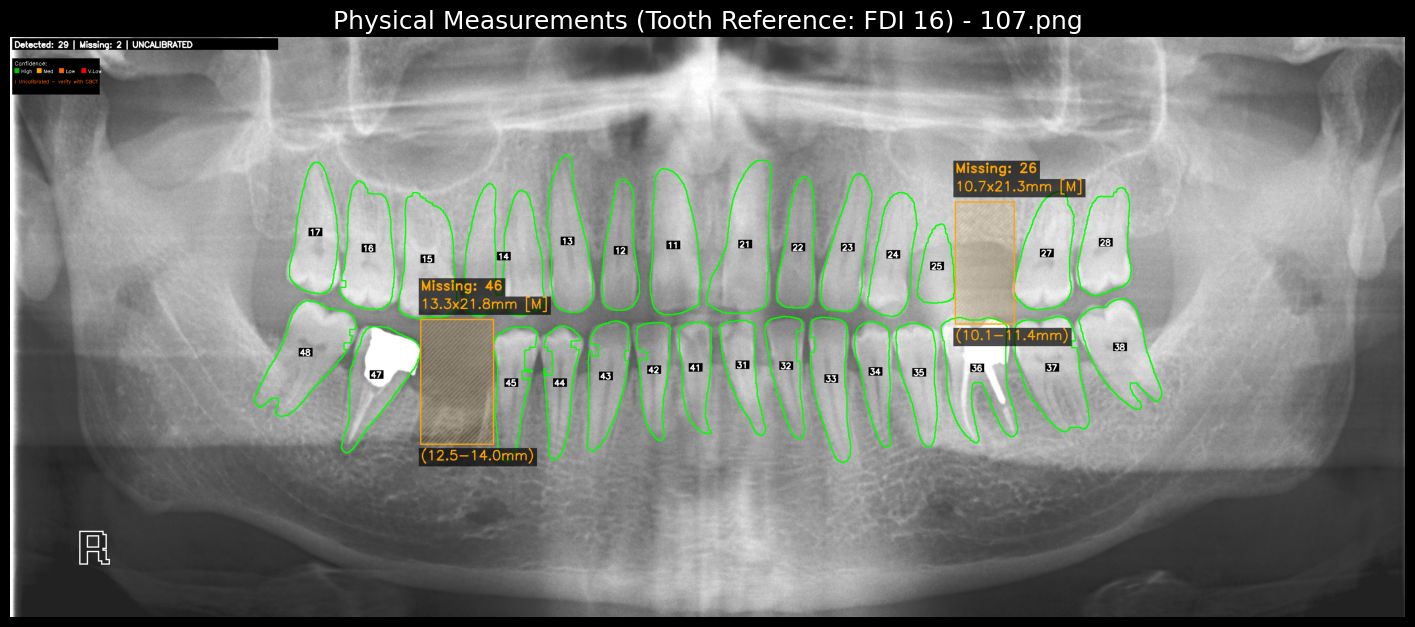

In [94]:
if molar_teeth:
    analysis_viz_tooth_ref = visualize_analysis_physical(
        original_image=img_bgr,
        result=analysis_result,
        priors=priors_tooth_ref,
        show_fdi_labels=True,
        show_zones=True,
        show_measurements=True,
        show_confidence=True,
    )

    plt.figure(figsize=(18, 12))
    plt.imshow(cv2.cvtColor(analysis_viz_tooth_ref, cv2.COLOR_BGR2RGB))
    plt.title(f'Physical Measurements (Tooth Reference: FDI {ref_tooth.fdi_number}) - {image_path.name}', fontsize=18)
    plt.axis('off')
    plt.show()
    # print("\n")
    # _ = print_physical_measurement_report(zones_physical_tooth_ref, priors_tooth_ref)

In [95]:
if 'priors_tooth_ref' in dir() and priors_tooth_ref is not None:
    METHOD_2_LABEL = f"Method 2: Tooth Reference ({priors_tooth_ref.calibration_method})"
    METHOD_2_SUBTITLE = f"Pixel spacing: {priors_tooth_ref.get_effective_pixel_spacing():.4f} mm/px | Reference: FDI {ref_tooth.fdi_number}"

    # Magnification bar chart for Method 2
    fig_mf_2 = create_magnification_chart(priors_tooth_ref, title_suffix=METHOD_2_SUBTITLE)
    fig_mf_2.show()

    # 3D->2D projection with detected teeth overlay (Method 2)
    fig_geom_2 = create_panoramic_geometry_visualization(
        priors=priors_tooth_ref,
        detected_teeth=analysis_result.detected_teeth,
        edentulous_zones=analysis_result.edentulous_zones,
        image_width_px=original_width,
        image_height_px=original_height,
        title_suffix=METHOD_2_SUBTITLE,
    )
    fig_geom_2.show()

    print(f"\n{METHOD_2_LABEL}")
    print(f"  {METHOD_2_SUBTITLE}")
else:
    print("Method 2 not available - no molar teeth detected for reference calibration")

# Print key insights
print_geometry_insights()


Method 2: Tooth Reference (manual_pixel_spacing)
  Pixel spacing: 0.0992 mm/px | Reference: FDI 16

KEY INSIGHTS - Panoramic X-ray Geometry:

1. HORIZONTAL measurements (width) are LESS reliable than VERTICAL (height)
   - Vertical uncertainty: +/-3% (consistent across all regions)
   - Horizontal uncertainty: +/-6% (molar) to +/-15% (anterior)

2. ANTERIOR region (incisors) has the HIGHEST horizontal uncertainty
   - X-ray beam is nearly parallel to the dental arch at the midline
   - This causes maximum horizontal distortion

3. MOLAR region has the LOWEST horizontal uncertainty
   - X-ray beam is more perpendicular to teeth in this region
   - Most reliable for mesiodistal width measurements

4. For IMPLANT PLANNING in the anterior region:
   - ALWAYS verify with CBCT
   - Panoramic width measurements can be off by 10-20%




In [96]:
if molar_teeth:
    print("\n" + "="*60)
    print("COMPARISON: FOV vs Tooth Reference Calibration")
    print("="*60)
    for i, (z_fov, z_ref) in enumerate(zip(zones_physical, zones_physical_tooth_ref)):
        print(f"\nZone {i+1} (Q{z_fov.quadrant}, Missing: {z_fov.missing_fdi_numbers}):")
        print(f"  FOV method:       {z_fov.width.value_mm:.1f}mm x {z_fov.height.value_mm:.1f}mm")
        print(f"  Tooth ref method: {z_ref.width.value_mm:.1f}mm x {z_ref.height.value_mm:.1f}mm")


COMPARISON: FOV vs Tooth Reference Calibration

Zone 1 (Q2, Missing: [26]):
  FOV method:       9.3mm x 18.6mm
  Tooth ref method: 10.7mm x 21.3mm

Zone 2 (Q4, Missing: [46]):
  FOV method:       11.5mm x 19.0mm
  Tooth ref method: 13.3mm x 21.8mm
